In [117]:
import keyring
import pandas as pd
from sqlalchemy import create_engine

password = keyring.get_password("mysql-rocketpig", "root")
user = 'root'
host = '220.76.59.96'
port = '3306'  # 기본적으로 MySQL은 3306 포트를 사용합니다
db = 'stock_db'

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset=utf8")

# 연결 테스트
with engine.connect() as connection:
    print("SQLAlchemy로 MySQL 연결 성공!")

SQLAlchemy로 MySQL 연결 성공!


In [118]:
import keyring
from pprint import pprint

api_key_irp = keyring.get_password("irp_api_key", "birdblues")
api_secret_irp = keyring.get_password("irp_api_secret", "birdblues")

api_key_isa = keyring.get_password("isa_api_key", "birdblues")
api_secret_isa = keyring.get_password("isa_api_secret", "birdblues")

api_key_0 = keyring.get_password("api_key_0", "birdblues")
api_secret_0 = keyring.get_password("api_secret_0","birdblues")

api_key_1 = keyring.get_password("api_key_1", "birdblues")
api_secret_1 = keyring.get_password("api_secret_1","birdblues")

api_key_2 = keyring.get_password("api_key_2", "birdblues")
api_secret_2 = keyring.get_password("api_secret_2","birdblues")

# print(f"api_key_irp = {api_key_irp}")
# print(f"api_secret_irp = {api_secret_irp}")
# print(f"api_key_isa = {api_key_isa}")
# print(f"api_secret_isa = {api_secret_isa}")
# print(f"api_key_0 = {api_key_0}")
# print(f"api_secret_0 = {api_secret_0}")
# print(f"api_key_1 = {api_key_1}")
# print(f"api_secret_1 = {api_secret_1}")
# print(f"api_key_2 = {api_key_2}")
# print(f"api_secret_2 = {api_secret_2}")

In [119]:
acc_no_0 = "63981494-01" # 위탁
acc_no_1 = "64267316-22" # 연금저축 1
acc_no_2 = "64012548-22" # 연금저축 2
acc_no_isa = "64043278-01" # ISA
acc_no_irp = "64012548-29" # IRP

In [120]:
token_0 = keyring.get_password("access_token_0", "birdblues")
token_1 = keyring.get_password("access_token_1", "birdblues")
token_2 = keyring.get_password("access_token_2", "birdblues")
token_3 = keyring.get_password("access_token_3", "birdblues")
token_4 = keyring.get_password("access_token_4", "birdblues")

In [121]:
import requests


def get_current_price(code):
    url_base = "https://openapi.koreainvestment.com:9443"
    path = "uapi/domestic-stock/v1/quotations/inquire-price"
    url = f"{url_base}/{path}"

    headers = {
        "Content-Type": "application/json",
        "authorization": f"Bearer {token_0}",
        "appKey": api_key_0,
        "appSecret": api_secret_0,
        "tr_id": "FHKST01010100"
    }

    params = {"fid_cond_mrkt_div_code": "J", "fid_input_iscd": code}

    res = requests.get(url, headers=headers, params=params)
    return res.json()['output']['stck_prpr']

In [122]:
query = "SELECT * FROM deposit"
입금 = pd.read_sql(query, con=engine)
입금.set_index('거래일', inplace=True)
query = "SELECT * FROM withdraw"
출금 = pd.read_sql(query, con=engine)
출금.set_index('거래일', inplace=True)
query = "SELECT * FROM distribution"
분배금 = pd.read_sql(query, con=engine)
분배금.set_index('거래일', inplace=True)
query = "SELECT * FROM interest"
이자 = pd.read_sql(query, con=engine)
이자.set_index('거래일', inplace=True)
query = "SELECT * FROM stock"
주식 = pd.read_sql(query, con=engine)
주식.set_index('거래일', inplace=True)

In [123]:
from datetime import datetime
import yfinance as yf
import requests

pd.set_option('future.no_silent_downcasting', True)

    
def get_stock_price(code, start_date):
    ticker = f'{code}.KS'
    today = datetime.today().strftime('%Y-%m-%d')
    stock_data = yf.download(ticker, start=start_date, end=today, progress=False)
    close_prices = stock_data[['Close']]
    close_prices = close_prices.resample('D').ffill()
    close_prices.loc[today, 'Close'] = float(get_current_price(code))
    # display(close_prices)
    return close_prices


def extend_today(df, start):
    # 오늘 날짜 가져오기
    today = datetime.today().strftime('%Y-%m-%d')
    # 일간으로 리샘플링하고, forward fill로 채우기
    date_range = pd.date_range(start=start, end=today, freq='D')
    df_resampled = pd.DataFrame(index=date_range)
    df_resampled = df_resampled.join(df)
    df_resampled.index.name = '거래일'
    return df_resampled


def current_balance(account):
    
    query = "SELECT * FROM deposit"
    입금 = pd.read_sql(query, con=engine)
    입금.set_index('거래일', inplace=True)
    query = "SELECT * FROM withdraw"
    출금 = pd.read_sql(query, con=engine)
    출금.set_index('거래일', inplace=True)
    query = "SELECT * FROM distribution"
    분배금 = pd.read_sql(query, con=engine)
    분배금.set_index('거래일', inplace=True)
    query = "SELECT * FROM interest"
    이자 = pd.read_sql(query, con=engine)
    이자.set_index('거래일', inplace=True)
    query = "SELECT * FROM stock"
    주식 = pd.read_sql(query, con=engine)
    주식.set_index('거래일', inplace=True)
    
    입금 = 입금[입금['계좌'] == account]
    출금 = 출금[출금['계좌'] == account]
    분배금 = 분배금[분배금['계좌'] == account]
    이자 = 이자[이자['계좌'] == account]
    주식 = 주식[주식['계좌'] == account]
    
    일별입금 = 입금.groupby('거래일').agg({'정산금': 'sum'})
    일별출금 = 출금.groupby('거래일').agg({'정산금': 'sum'})
    일별분배금 = 분배금.groupby('거래일').agg({'정산금': 'sum'})
    일별이자 = 이자.groupby('거래일').agg({'정산금': 'sum'})
    일별주식 = 주식.groupby('거래일').agg({
        '정산금': 'sum', 
        '매수금액': 'sum', 
        '매도금액': 'sum', 
        '수수료': 'sum', 
        '세금': 'sum'})

    일별입금 = 일별입금.resample('D').sum().fillna(0)
    일별출금 = 일별출금.resample('D').sum().fillna(0)
    일별분배금 = 일별분배금.resample('D').sum().fillna(0)
    일별이자 = 일별이자.resample('D').sum().fillna(0)
    일별주식 = 일별주식.resample('D').sum().fillna(0)

    일별입금.columns = ['입금']
    일별출금.columns = ['출금']
    일별분배금.columns = ['분배금']
    일별이자.columns = ['이자']
    일별주식.columns = ['주식', '매수금액', '매도금액', '수수료', '세금']

    입출금 = pd.concat([일별입금, 일별출금, 일별분배금, 일별이자, 일별주식], axis=1).fillna(0)
    입출금['입출금'] = 입출금['입금'] - 입출금['출금']
    입출금['입출금'] = 입출금['입출금'].cumsum()
    입출금['총현금'] = 입출금['입금'] - 입출금['출금'] + 입출금['분배금'] + 입출금['이자'] + 입출금['주식']
    입출금['총현금'] = 입출금['총현금'].cumsum()
    # 입출금['변화량'] = 입출금['총현금'].diff()
    
    입출금 = extend_today(입출금, 입출금.index.min()).ffill().fillna(0)

    df = pd.DataFrame()

    for code in 주식['코드'].unique():
        주식코드 = 주식[주식['코드'] == code].copy()
    
        주식코드 = 주식코드.pivot_table(index=['거래일'], columns='계좌', values=['코드', '상품명', '보유'], aggfunc='first').ffill().fillna(0)
        주식코드합 = 주식코드.T.groupby(level=0).sum().T
        # 주식코드합.columns = [code]
        주식코드합 = extend_today(주식코드합, 주식.index.min()).ffill().fillna(0)
        주식가격 = get_stock_price(code, 주식.index.min())
        주식가격 = extend_today(주식가격, 주식.index.min()).ffill()
        주식코드합["평가금"] = 주식코드합['보유'] * 주식가격['Close']
        # 주식코드합["평가금"] = 주식코드합['보유'] * 주식가격['Close']
        # 주식코드합 = 주식코드합[['코드', '상품명', '보유', '평가금']]
        name = 주식코드['상품명'].iloc[0]
        주식코드합 = 주식코드합[['평가금']]
        주식코드합.columns = [name]
        # display(주식코드)
        # display(주식코드합)
        
        df = pd.concat([df, 주식코드합], axis=1).fillna(0)

    입출금['평가금'] = df.sum(axis=1)
    입출금['총자산'] = 입출금['총현금'] + 입출금['평가금']
    
    return df, 입출금

b1, c1 = current_balance(acc_no_1)
b2, c2 = current_balance(acc_no_2)
b3, c3 = current_balance(acc_no_isa)
b4, c4 = current_balance(acc_no_irp)


In [124]:

c = pd.concat([c1, c2, c3, c4])
c = c.groupby(c.index).sum()
c

# b = pd.concat([b1, b2, b3, b4], axis=1).fillna(0)
# b = b.groupby(b.columns, axis=1).sum()
# b

,입금,출금,분배금,이자,주식,매수금액,매도금액,수수료,세금,입출금,총현금,평가금,총자산
거래일,,,,,,,,,,,,,
2023-12-22,6000000.0,0.0,0.0,0.0,-878000.0,878000.0,0.0,0.0,0.0,6000000.0,5122000.0,878390.0,1000390.0
2023-12-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6000000.0,5122000.0,878390.0,1000390.0
2023-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6000000.0,5122000.0,878390.0,1000390.0
2023-12-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6000000.0,5122000.0,878390.0,1000390.0
2023-12-26,0.0,0.0,0.0,382.0,0.0,0.0,0.0,0.0,0.0,6000000.0,5122382.0,878615.0,1000997.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99941246.0,18731.0,103388495.0,103407226.0
2024-09-09,0.0,0.0,0.0,0.0,1196433.0,989010.0,2185575.0,132.0,0.0,99941246.0,1215164.0,102364365.0,103579529.0
2024-09-10,0.0,0.0,0.0,0.0,362762.0,334750.0,697550.0,38.0,0.0,99941246.0,1577926.0,102524545.0,104102471.0


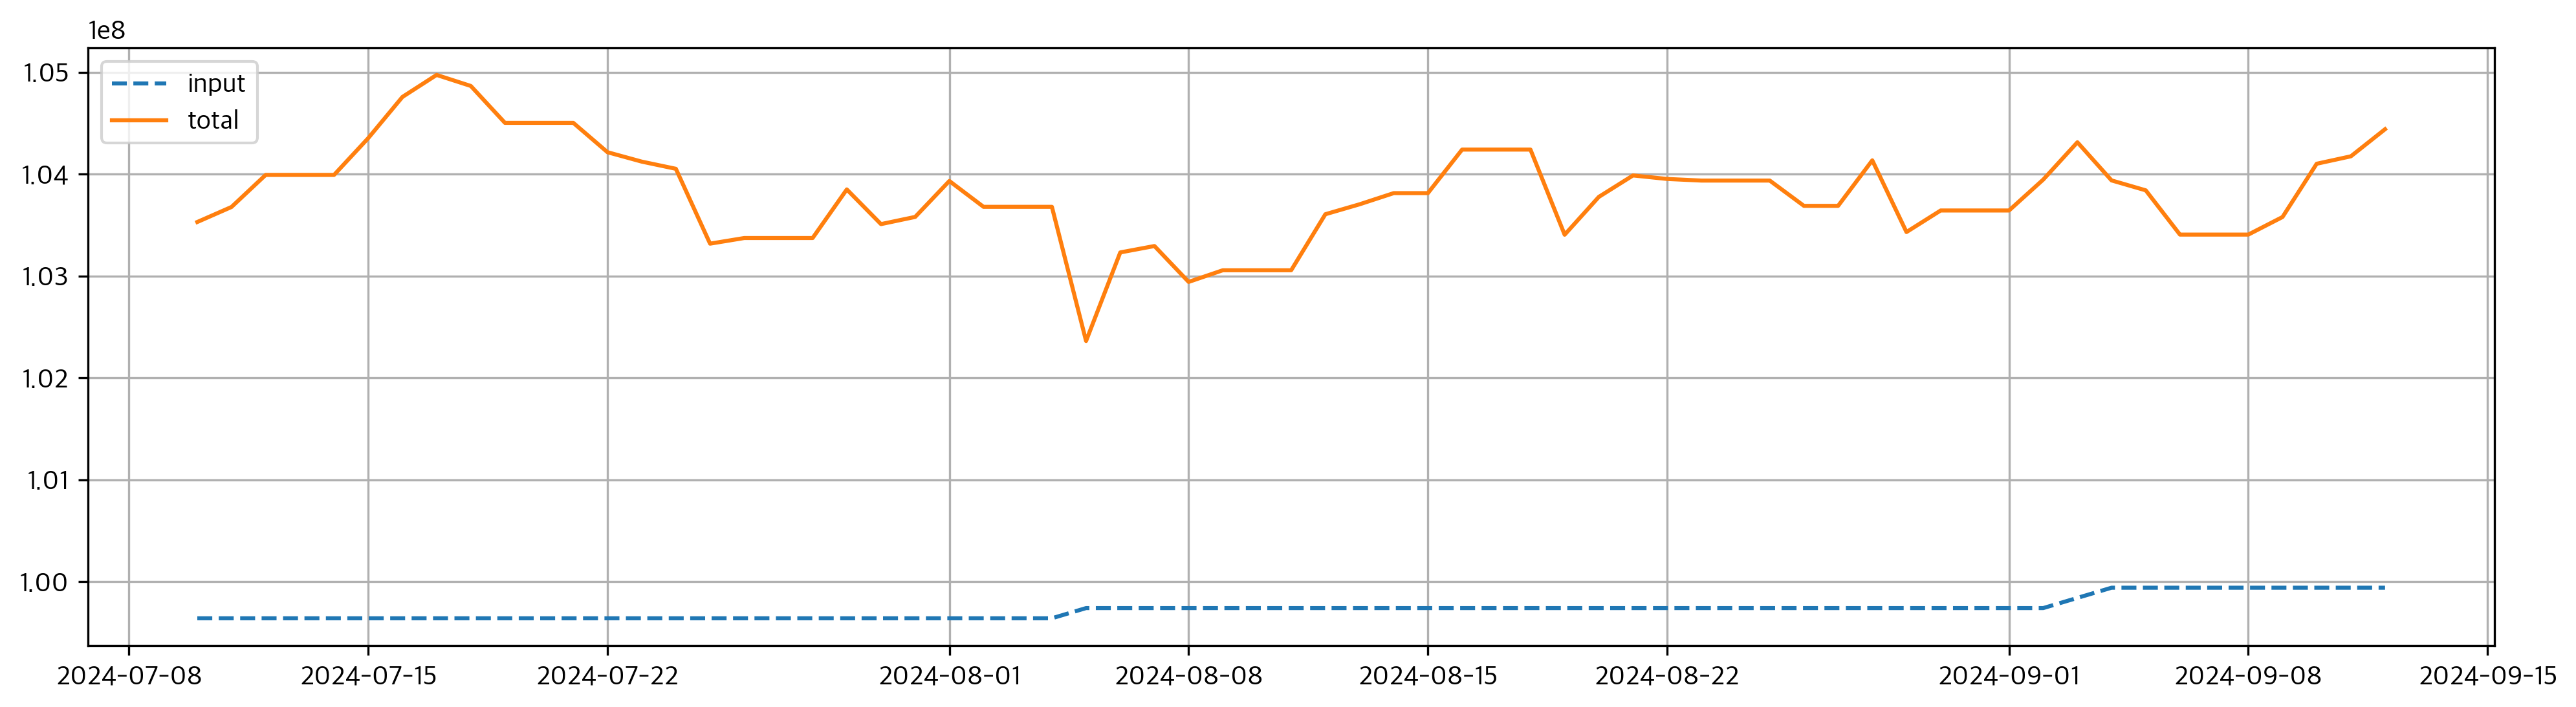

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
plt.plot(c.loc['2024-07-10':,'입출금'], label='input', linestyle='--')
plt.plot(c.loc['2024-07-10':,'총자산'], label='total')
plt.grid(True)
plt.legend()

In [126]:
def display_balance(df, account):
    총매수금액 = df['매수금액'].sum()
    총매도금액 = df['매도금액'].sum()
    전체수수료 = df['수수료'].sum()
    전체세금 = df['세금'].sum()
    전체입금 = df['입금'].sum()
    전체출금 = df['출금'].sum()
    전체분배금 = df['분배금'].sum()
    전체이자 = df['이자'].sum()

    주식정산금 = 총매도금액 - 총매수금액 - 전체수수료 - 전체세금
    총입금 = 전체입금 - 전체출금 + 전체분배금 + 전체이자

    display(f'account:{account}, 총매도금액:{총매도금액}, 총매수금액:{총매수금액} 전체수수료:{전체수수료}, 전체세금:{전체세금}, 총입금:{총입금}, 주식정산금:{주식정산금}, 총입금 + 주식정산금:{총입금 + 주식정산금}')
    return 총입금 + 주식정산금

In [127]:
예수금1 = display_balance(c1, acc_no_1)
예수금2 = display_balance(c2, acc_no_2)
예수금3 = display_balance(c3, acc_no_isa)
예수금4 = display_balance(c4, acc_no_irp)

총예수금 = 예수금1 + 예수금2 + 예수금3 + 예수금4
총예수금

'account:64267316-22, 총매도금액:77247660.0, 총매수금액:124093625.0 전체수수료:8401.0, 전체세금:0.0, 총입금:48059823.0, 주식정산금:-46854366.0, 총입금 + 주식정산금:1205457.0'

'account:64012548-22, 총매도금액:66999850.0, 총매수금액:78071215.0 전체수수료:5988.0, 전체세금:0.0, 총입금:12113331.0, 주식정산금:-11077353.0, 총입금 + 주식정산금:1035978.0'

'account:64043278-01, 총매도금액:69752205, 총매수금액:75574025 전체수수료:6057, 전체세금:28770, 총입금:7118022.0, 주식정산금:-5856647, 총입금 + 주식정산금:1261375.0'

'account:64012548-29, 총매도금액:28403600.0, 총매수금액:62031830.0 전체수수료:0.0, 전체세금:0.0, 총입금:33902514.0, 주식정산금:-33628230.0, 총입금 + 주식정산금:274284.0'

3777094.0